In [22]:
#!pip install llama-index-core

In [23]:
#%pip install llama-index-utils-workflow

## Basic Workflow

In [3]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
)

In [4]:
class MyWorkflow(Workflow):
    @step
    async def my_step(self, ev: StartEvent) -> StopEvent:
        # do something here
        return StopEvent(result="Hello, world!")


w = MyWorkflow(timeout=10, verbose=False)
result = await w.run()
print(result)

Hello, world!


In [5]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(
    MyWorkflow,
    filename="basic_workflow.html",
    # Optional, can limit long event names in your workflow
    # Can help with readability
    # max_label_length=10,
)

basic_workflow.html


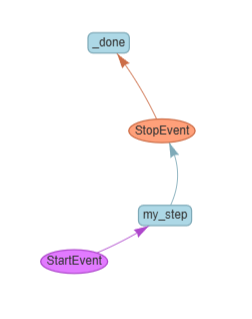

## Multi-step Workflow

In [6]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event,
)
from llama_index.utils.workflow import draw_all_possible_flows

In [7]:
class FirstEvent(Event):
    first_output: str


class SecondEvent(Event):
    second_output: str

class MyWorkflow(Workflow):
    @step
    async def step_one(self, ev: StartEvent) -> FirstEvent:
        print(ev.first_input)
        return FirstEvent(first_output="First step complete.")

    @step
    async def step_two(self, ev: FirstEvent) -> SecondEvent:
        print(ev.first_output)
        return SecondEvent(second_output="Second step complete.")

    @step
    async def step_three(self, ev: SecondEvent) -> StopEvent:
        print(ev.second_output)
        return StopEvent(result="Workflow complete.")


w = MyWorkflow(timeout=10, verbose=False)
result = await w.run(first_input="Start the workflow.")
print(result)

Start the workflow.
First step complete.
Second step complete.
Workflow complete.


In [8]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(MyWorkflow, filename="multi_step_workflow.html")

multi_step_workflow.html


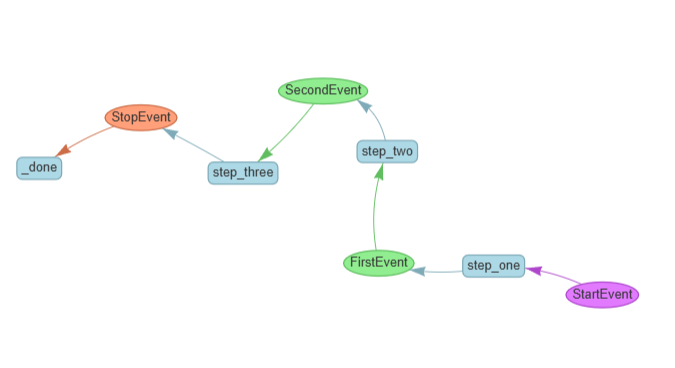

## Branched workflow

In [9]:
import random
class BranchA1Event(Event):
    payload: str


class BranchA2Event(Event):
    payload: str


class BranchB1Event(Event):
    payload: str


class BranchB2Event(Event):
    payload: str


class BranchWorkflow(Workflow):
    @step
    async def start(self, ev: StartEvent) -> BranchA1Event | BranchB1Event:
        if random.randint(0, 1) == 0:
            print("Go to branch A")
            return BranchA1Event(payload="Branch A")
        else:
            print("Go to branch B")
            return BranchB1Event(payload="Branch B")

    @step
    async def step_a1(self, ev: BranchA1Event) -> BranchA2Event:
        print(ev.payload)
        return BranchA2Event(payload=ev.payload)

    @step
    async def step_b1(self, ev: BranchB1Event) -> BranchB2Event:
        print(ev.payload)
        return BranchB2Event(payload=ev.payload)

    @step
    async def step_a2(self, ev: BranchA2Event) -> StopEvent:
        print(ev.payload)
        return StopEvent(result="Branch A complete.")

    @step
    async def step_b2(self, ev: BranchB2Event) -> StopEvent:
        print(ev.payload)
        return StopEvent(result="Branch B complete.")
    
draw_all_possible_flows(BranchWorkflow, filename="branch_workflow.html")

branch_workflow.html


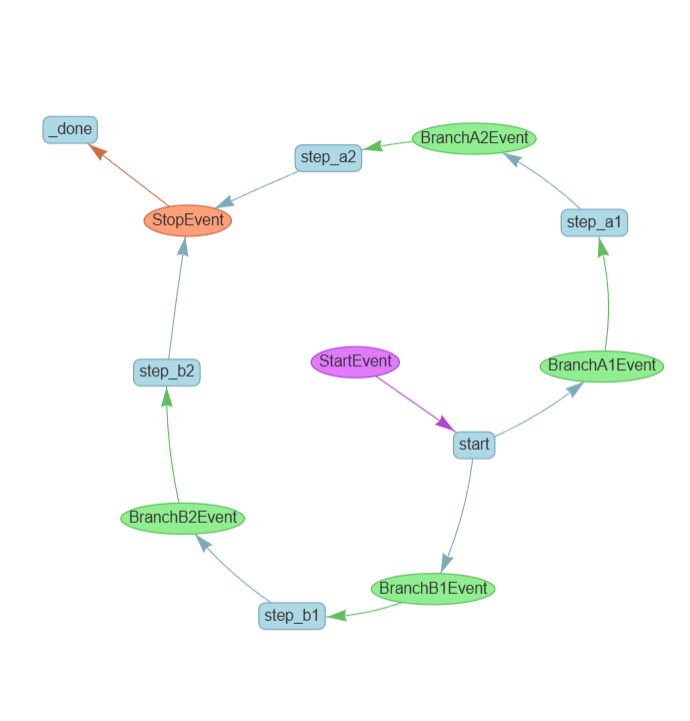

## Streaming Events

To provide user with an indication of progress by streaming events as they occur. 

In [14]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event,
    Context,
)
import asyncio
from llama_index.llms.groq import Groq
from llama_index.utils.workflow import draw_all_possible_flows

In [19]:
class FirstEvent(Event):
    first_output: str


class SecondEvent(Event):
    second_output: str
    response: str


class ProgressEvent(Event):
    msg: str

class MyWorkflow(Workflow):
    @step
    async def step_one(self, ctx: Context, ev: StartEvent) -> FirstEvent:
        ctx.write_event_to_stream(ProgressEvent(msg="Step one is happening"))
        return FirstEvent(first_output="First step complete.")

    @step
    async def step_two(self, ctx: Context, ev: FirstEvent) -> SecondEvent:
        llm = Groq(model="llama3-8b-8192", temperature=0.1)
        generator = await llm.astream_complete(
            "Please give me the first 3 paragraphs of Moby Dick, a book in the public domain."
        )
        full_response = ""
        async for response in generator:
            ctx.write_event_to_stream(ProgressEvent(msg=response.delta))
            full_response += response.delta

        return SecondEvent(
            second_output="Second step complete, full response attached",
            response=full_response,
        )


    @step
    async def step_three(self, ctx: Context, ev: SecondEvent) -> StopEvent:
        ctx.write_event_to_stream(ProgressEvent(msg="Step three is happening"))
        return StopEvent(result="Workflow complete.")

- run runs the workflow in the background
- stream_events will provide any event that gets written to the stream. It stops when the stream delivers a StopEvent, after which you can get the final result of the workflow as you normally would

In [21]:
w = MyWorkflow(timeout=30, verbose=True)
handler = w.run(first_input="Start the workflow.")

async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print(ev.msg, end="", flush=True)


final_result = await handler
print("Final result", final_result)

draw_all_possible_flows(MyWorkflow, filename="streaming_workflow.html")

Running step step_one
Step step_one produced event FirstEvent
Running step step_two
Step one is happeningHere are the first three paragraphs of Moby Dick by Herman Melville:

"Call me Ishmael. Some years ago—never mind how long precisely—having little or no money in my purse, and nothing particular to interest me on shore, I thought I would sail about a little and see the watery part of the world. It is a way I have of driving off the spleen and regulating the circulation. Whenever I find myself growing grim about the mouth; whenever it is a damp, drizzly November in my soul; whenever I find myself involuntarily pausing before coffin warehouses, and bringing up the rear of every funeral I meet; and especially whenever my hypos get such an upper hand of me, that it requires a strong moral principle to prevent me from deliberately stepping into the street, and methodically knocking people's hats off—then, I account it high time to get to sea as soon as I can. This is my substitute for pi

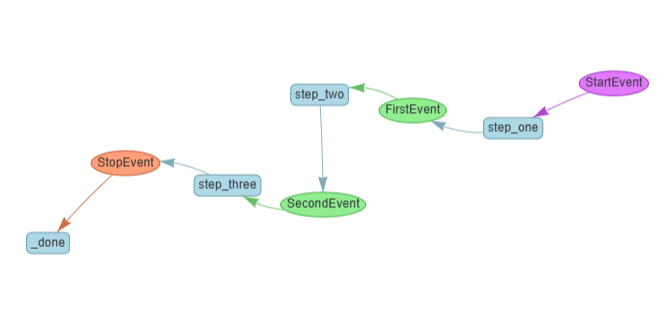